# Self-Driiving Car
This tutorial shows how to use deep learning for an autonomous vehicle agent by using Keras library.


## Gathering Data
To gather data, we would use [Udacity’s self-driving car simulator](https://github.com/udacity/self-driving-car-sim).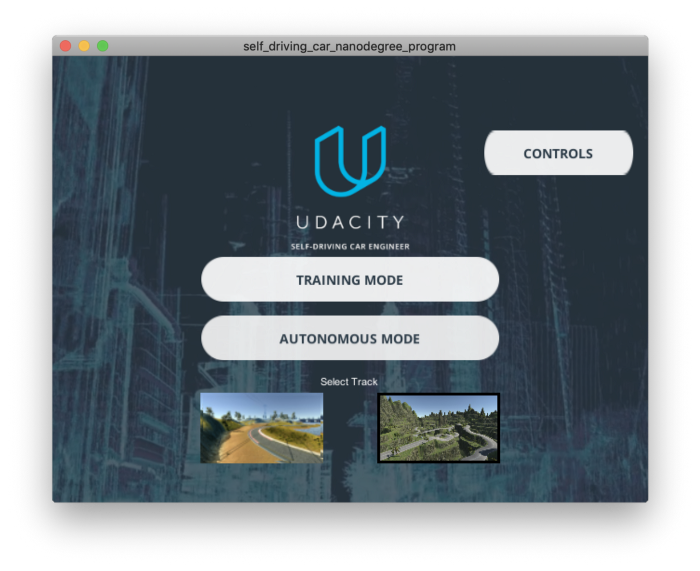

 First we need to create a folder in our project directory. Now, run the training mode. Once you enter the training mode, click the record button.
 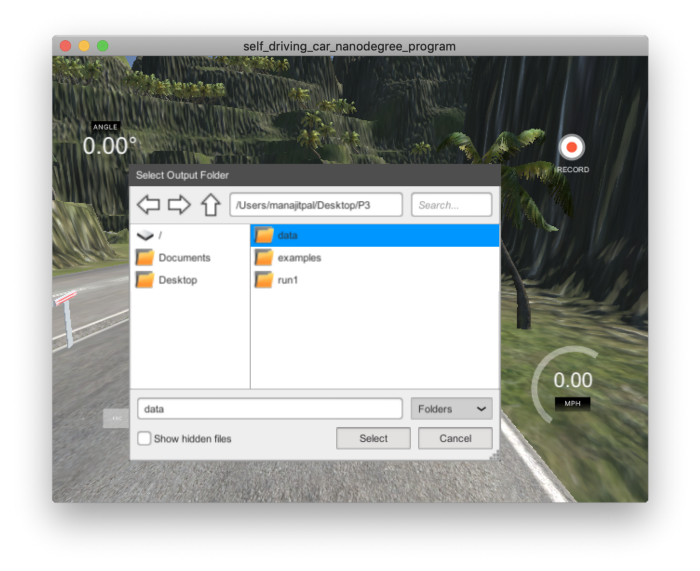 

Now you can save your data by pressing the record button one more time. You can also use [the data provided by Udacity](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip).

## Environment
We recommend to use [Colab](https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index), which has all the libraries we need for this code.

In [7]:
import csv
import numpy as np
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Lambda, Dropout
from keras.layers.convolutional import Cropping2D
from keras.optimizers import Adam

ModuleNotFoundError: No module named 'cv2'

In [ ]:
#getting data
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip


--2021-06-05 09:58:55--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.224.2.183, 13.224.2.204, 13.224.2.59, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.224.2.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 317.70M  31.3MB/s    in 11s     

2021-06-05 09:59:07 (29.6 MB/s) - ‘data.zip’ saved [333137665/333137665]



In [ ]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_298.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_400.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_400.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_502.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_502.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_604.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_604.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_705.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_705.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_806.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_806.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_906.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_906.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_29_007.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_29_0

In [ ]:

samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)




In [ ]:

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3): # center, left and rights images
                    name = 'data/IMG/' + batch_sample[i].split('/')[-1]
                    current_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    images.append(current_image)
                    
                    center_angle = float(batch_sample[3])
                    if i == 0:
                        angles.append(center_angle)
                    elif i == 1: 
                        angles.append(center_angle + 0.4)
                    elif i == 2: 
                        angles.append(center_angle - 0.4)
                    
                    images.append(cv2.flip(current_image, 1))
                    if i == 0:
                        angles.append(center_angle * -1.0)
                    elif i == 1: 
                        angles.append((center_angle + 0.4) * -1.0)
                    elif i == 2: 
                        angles.append((center_angle - 0.4) * -1.0)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield tuple(sklearn.utils.shuffle(X_train, y_train))



In [ ]:
train_samples, validation_samples = train_test_split(samples[1:], test_size=0.2)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


##Model


In [ ]:
# nVidia model
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Conv2D(24,(5,5), strides=(2,2), activation='elu'))
model.add(Conv2D(36,(5,5), strides=(2,2), activation='elu'))
model.add(Conv2D(48,(5,5), strides=(2,2), activation='elu'))
model.add(Conv2D(64,(3,3), activation='elu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 35, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 3, 35, 64)         0

#Use GPU on Colab
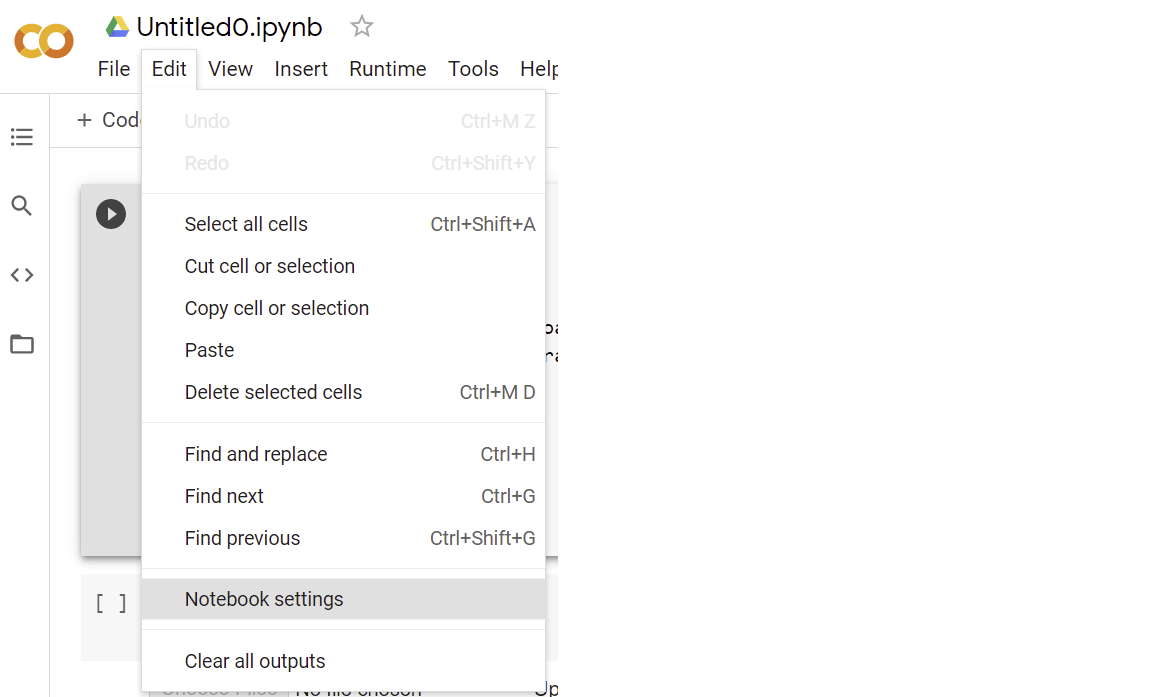
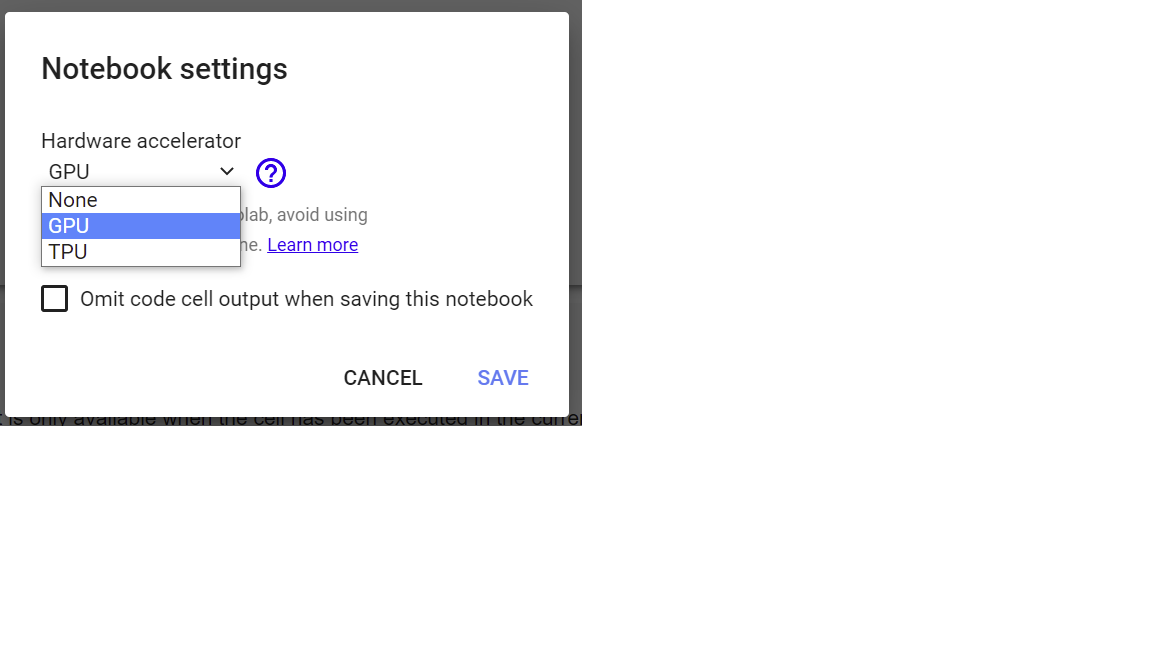

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=len(train_samples),validation_data=validation_generator, validation_steps=len(validation_samples), epochs=5, verbose = 1)
model.save('model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
6428/6428 [==============================] - 1055s 157ms/step - loss: 0.0347 - val_loss: 0.0484
Epoch 2/5
6428/6428 [==============================] - 1007s 157ms/step - loss: 0.0074 - val_loss: 0.0454
Epoch 3/5
6428/6428 [==============================] - 1007s 157ms/step - loss: 0.0050 - val_loss: 0.0430
Epoch 4/5
6428/6428 [==============================] - 1016s 158ms/step - loss: 0.0038 - val_loss: 0.0416
Epoch 5/5
6428/6428 [==============================] - 1004s 156ms/step - loss: 0.0034 - val_loss: 0.0386


Now we need a code to connect our model to the simulator, get the frames of the track from the simulator to process through our model and send the steering prediction back to the simulator.